# PyTorch Deep Learning: MNIST 手寫數字分類實作

## 📖 使用說明

### 執行方式：
1. **必須按順序執行前面的 Cell**：
   - Cell 1: 導入套件（必須先執行）
   - Cell 3: 載入資料集（必須先執行）
   - Cell 5, 7: 定義模型類別（必須先執行）
   - Cell 9, 11: 定義訓練和視覺化函數（必須先執行）

2. **基礎實驗**：
   - Cell 13-15: 執行基礎設定的訓練（建議先執行，作為對照組）

3. **修改實驗**（可選擇執行）：
   - 至少需要執行 **3 個修改實驗**（符合作業要求）
   - 每個實驗都是獨立的，可以選擇性執行
   - 建議執行順序：實驗 1 → 實驗 2 → 實驗 3（或其他組合）

4. **結果比較**：
   - Cell 29: 執行結果比較（需要先執行基礎設定和至少 3 個實驗）

### 執行環境：
- **Google Colab**：直接上傳 `.ipynb` 檔案，點擊「執行全部」或逐個執行
- **本地環境**：需要安裝 PyTorch、torchvision、matplotlib 等套件

### 注意事項：
- ⚠️ 每個實驗的訓練時間約 1-5 分鐘（取決於硬體）
- ⚠️ 第一次執行會自動下載 MNIST 資料集（約 60MB）
- ⚠️ 如果只想快速測試，可以將 Epochs 設為 1-2

---

## 作業目標
- 熟悉 Python 基本語法與程式執行方法
- 理解神經網路的基本概念（輸入層、隱藏層、輸出層）
- 使用 PyTorch 執行範例程式
- 理解訓練參數（epoch、batch size、learning rate）對結果的影響
- 觀察並解釋訓練過程中 loss 和 accuracy 的變化


In [4]:
# 導入必要的套件
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# 設定中文字體（如果需要顯示中文）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("PyTorch 版本:", torch.__version__)
print("CUDA 可用:", torch.cuda.is_available())


PyTorch 版本: 2.9.0+cpu
CUDA 可用: False


## 資料載入與預處理


In [5]:
# 定義資料轉換
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST 的平均值和標準差
])

# 載入訓練資料集
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# 載入測試資料集
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"訓練資料數量: {len(train_dataset)}")
print(f"測試資料數量: {len(test_dataset)}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 36.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.07MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.47MB/s]


訓練資料數量: 60000
測試資料數量: 10000


## 模型定義

### 選項 1: MLP (Multi-Layer Perceptron) 模型


In [6]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size1=128, hidden_size2=64, num_classes=10):
        """
        MLP 模型定義
        Args:
            input_size: 輸入層大小 (28*28 = 784)
            hidden_size1: 第一個隱藏層神經元數量
            hidden_size2: 第二個隱藏層神經元數量（如果為0則不使用第二層）
            num_classes: 輸出類別數量 (0-9)
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        
        # 【修改區塊 1】增加額外的隱藏層
        if hidden_size2 > 0:
            self.fc2 = nn.Linear(hidden_size1, hidden_size2)
            self.relu2 = nn.ReLU()
            self.fc3 = nn.Linear(hidden_size2, num_classes)
        else:
            self.fc2 = None
            self.fc3 = nn.Linear(hidden_size1, num_classes)
        
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # 將圖片展平
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        
        if self.fc2 is not None:
            x = self.fc2(x)
            x = self.relu2(x)
            x = self.dropout(x)
            x = self.fc3(x)
        else:
            x = self.fc3(x)
        
        return x


### 選項 2: CNN (Convolutional Neural Network) 模型


In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        """
        CNN 模型定義
        """
        super(CNN, self).__init__()
        # 第一個卷積層
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # 第二個卷積層
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # 全連接層
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


## 訓練函數


In [8]:
def train_model(model, train_loader, test_loader, num_epochs, optimizer, criterion, device):
    """
    訓練模型並記錄訓練過程
    """
    model = model.to(device)
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        # 訓練階段
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # 前向傳播
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 反向傳播
            loss.backward()
            optimizer.step()
            
            # 統計
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_train_acc)
        
        # 測試階段
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        epoch_test_acc = 100 * correct_test / total_test
        test_accuracies.append(epoch_test_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {epoch_loss:.4f}, '
              f'Train Acc: {epoch_train_acc:.2f}%, '
              f'Test Acc: {epoch_test_acc:.2f}%')
    
    return train_losses, train_accuracies, test_accuracies


## 視覺化函數


In [9]:
def plot_results(train_losses, train_accuracies, test_accuracies, title="訓練結果"):
    """
    繪製訓練過程的 loss 和 accuracy 曲線
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss 曲線
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('訓練 Loss 曲線')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy 曲線
    ax2.plot(train_accuracies, label='Training Accuracy', color='green', linestyle='--')
    ax2.plot(test_accuracies, label='Test Accuracy', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('訓練 Accuracy 曲線')
    ax2.legend()
    ax2.grid(True)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"\n最終測試準確率: {test_accuracies[-1]:.2f}%")


## 實驗設定與執行

### 基礎設定（原始設定）


In [10]:
# 設定裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用裝置: {device}")

# 【修改區塊 2】訓練參數設定
BATCH_SIZE = 64  # 原始: 64
NUM_EPOCHS = 5   # 原始: 5
LEARNING_RATE = 0.001  # 原始: 0.001

# 【修改區塊 3】模型參數設定
HIDDEN_SIZE1 = 128  # 第一個隱藏層神經元數量（原始: 128）
HIDDEN_SIZE2 = 0    # 第二個隱藏層神經元數量（0表示不使用，原始: 0）

# 【修改區塊 4】優化器選擇 ('adam' 或 'sgd')
OPTIMIZER_TYPE = 'adam'  # 原始: 'adam'

# 選擇模型類型 ('mlp' 或 'cnn')
MODEL_TYPE = 'mlp'  # 可以改為 'cnn'

print(f"\n=== 實驗設定 ===")
print(f"模型類型: {MODEL_TYPE.upper()}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Optimizer: {OPTIMIZER_TYPE.upper()}")
if MODEL_TYPE == 'mlp':
    print(f"隱藏層1神經元數: {HIDDEN_SIZE1}")
    if HIDDEN_SIZE2 > 0:
        print(f"隱藏層2神經元數: {HIDDEN_SIZE2}")


使用裝置: cpu

=== 實驗設定 ===
模型類型: MLP
Batch Size: 64
Epochs: 5
Learning Rate: 0.001
Optimizer: ADAM
隱藏層1神經元數: 128


In [11]:
# 建立 DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 建立模型
if MODEL_TYPE == 'mlp':
    model = MLP(hidden_size1=HIDDEN_SIZE1, hidden_size2=HIDDEN_SIZE2)
else:
    model = CNN()

# 定義損失函數
criterion = nn.CrossEntropyLoss()

# 【修改區塊 5】選擇優化器
if OPTIMIZER_TYPE == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
elif OPTIMIZER_TYPE == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
else:
    raise ValueError("Optimizer must be 'adam' or 'sgd'")

print(f"\n模型參數數量: {sum(p.numel() for p in model.parameters()):,}")



模型參數數量: 101,770



=== 開始訓練 ===

Epoch [1/5], Loss: 0.2863, Train Acc: 91.47%, Test Acc: 95.98%
Epoch [2/5], Loss: 0.1390, Train Acc: 95.77%, Test Acc: 96.56%
Epoch [3/5], Loss: 0.1107, Train Acc: 96.54%, Test Acc: 97.51%
Epoch [4/5], Loss: 0.0889, Train Acc: 97.26%, Test Acc: 97.39%


/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


Epoch [5/5], Loss: 0.0779, Train Acc: 97.55%, Test Acc: 97.71%


/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 30990 (\N{CJK UNIFIED IDEOGRAPH-790E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 35373 (\N{CJK UNIFIED IDEOGRAPH-8A2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35347 (\N

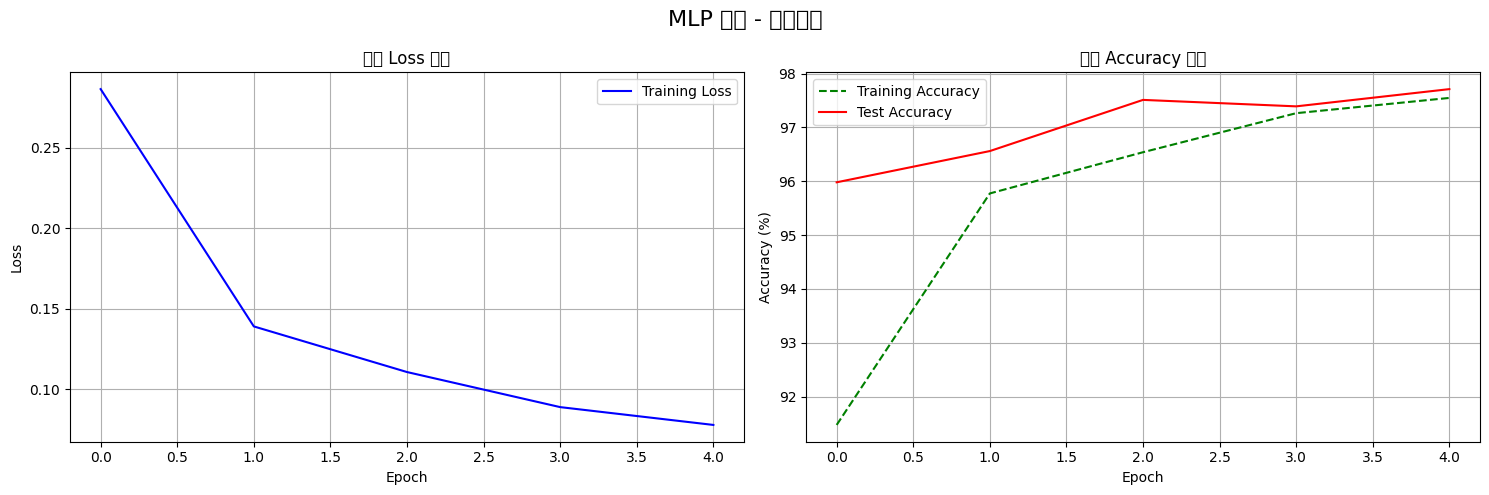


最終測試準確率: 97.71%


In [12]:
# 開始訓練
print("\n=== 開始訓練 ===\n")
train_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, NUM_EPOCHS, optimizer, criterion, device
)

# 繪製結果
plot_results(train_losses, train_accuracies, test_accuracies, 
             title=f"{MODEL_TYPE.upper()} 模型 - 基礎設定")


## 修改實驗 1: 調整隱藏層神經元數量（128 → 256）



=== 實驗 1: 隱藏層神經元數量調整 ===
隱藏層1神經元數: 256 (原始: 128)
Epoch [1/5], Loss: 0.2494, Train Acc: 92.61%, Test Acc: 95.87%
Epoch [2/5], Loss: 0.1160, Train Acc: 96.52%, Test Acc: 97.37%
Epoch [3/5], Loss: 0.0863, Train Acc: 97.31%, Test Acc: 97.58%
Epoch [4/5], Loss: 0.0685, Train Acc: 97.88%, Test Acc: 97.85%


/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


Epoch [5/5], Loss: 0.0601, Train Acc: 98.03%, Test Acc: 97.95%


/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 39511 (\N{CJK UNIFIED IDEOGRAPH-9A57}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 38577 (\N{CJK UNIFIED IDEOGRAPH-96B1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 34255 (\N{CJK UNIFIED IDEOGRAPH-85CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 23652 (\N{CJK UNIFIED IDEOGRAPH-5C64}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 31070 (\N{CJK UNIFIED IDEOGRAPH-795E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32147 (\N{CJK UNIFIED IDEOGRAPH-7D93}) missi

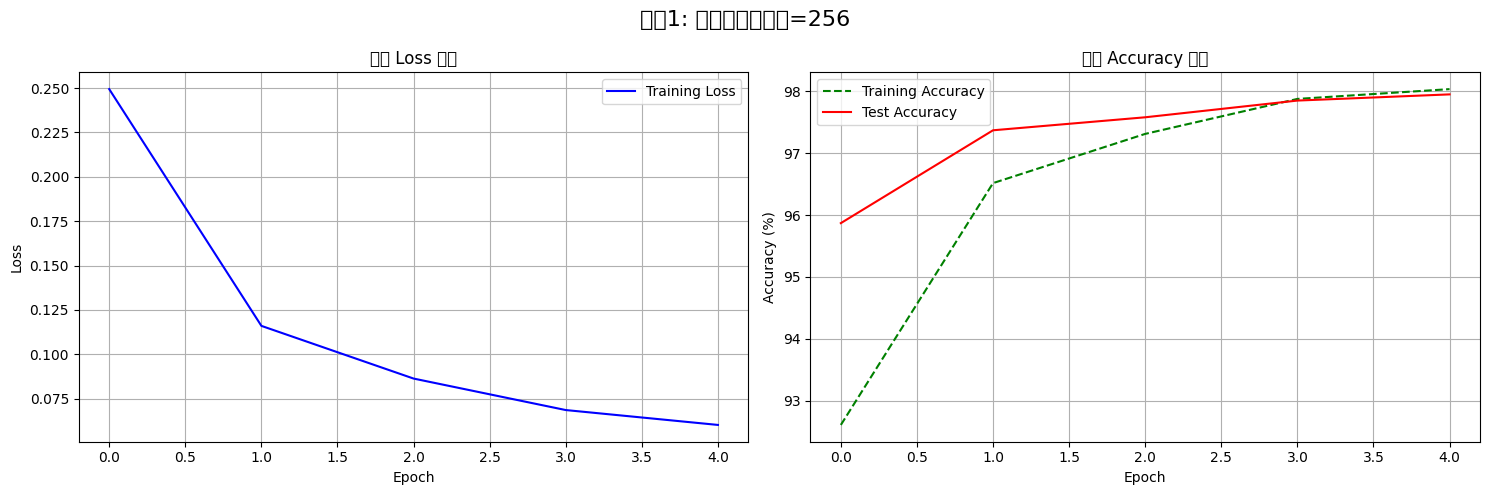


最終測試準確率: 97.95%


In [13]:
# 【修改區塊 1】調整隱藏層神經元數量
MODEL_TYPE = 'mlp'
HIDDEN_SIZE1 = 256  # 從 128 增加到 256
HIDDEN_SIZE2 = 0
BATCH_SIZE = 64
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
OPTIMIZER_TYPE = 'adam'

print(f"\n=== 實驗 1: 隱藏層神經元數量調整 ===")
print(f"隱藏層1神經元數: {HIDDEN_SIZE1} (原始: 128)")

# 重新建立模型和優化器
if MODEL_TYPE == 'mlp':
    model_exp1 = MLP(hidden_size1=HIDDEN_SIZE1, hidden_size2=HIDDEN_SIZE2)
else:
    model_exp1 = CNN()

if OPTIMIZER_TYPE == 'adam':
    optimizer_exp1 = optim.Adam(model_exp1.parameters(), lr=LEARNING_RATE)
else:
    optimizer_exp1 = optim.SGD(model_exp1.parameters(), lr=LEARNING_RATE, momentum=0.9)

# 訓練
train_losses_exp1, train_accuracies_exp1, test_accuracies_exp1 = train_model(
    model_exp1, train_loader, test_loader, NUM_EPOCHS, optimizer_exp1, criterion, device
)

# 繪製結果
plot_results(train_losses_exp1, train_accuracies_exp1, test_accuracies_exp1,
             title=f"實驗1: 隱藏層神經元數={HIDDEN_SIZE1}")


## 修改實驗 2: 增加額外的隱藏層



=== 實驗 2: 增加額外的隱藏層 ===
隱藏層1神經元數: 128
隱藏層2神經元數: 64 (新增)
Epoch [1/5], Loss: 0.3557, Train Acc: 89.17%, Test Acc: 95.67%
Epoch [2/5], Loss: 0.1707, Train Acc: 94.98%, Test Acc: 96.47%
Epoch [3/5], Loss: 0.1376, Train Acc: 95.84%, Test Acc: 97.23%
Epoch [4/5], Loss: 0.1169, Train Acc: 96.48%, Test Acc: 97.37%


/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


Epoch [5/5], Loss: 0.1033, Train Acc: 96.88%, Test Acc: 97.43%


/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 39511 (\N{CJK UNIFIED IDEOGRAPH-9A57}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 38617 (\N{CJK UNIFIED IDEOGRAPH-96D9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 38577 (\N{CJK UNIFIED IDEOGRAPH-96B1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 34255 (\N{CJK UNIFIED IDEOGRAPH-85CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 23652 (\N{CJK UNIFIED IDEOGRAPH-5C64}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38617 (\N

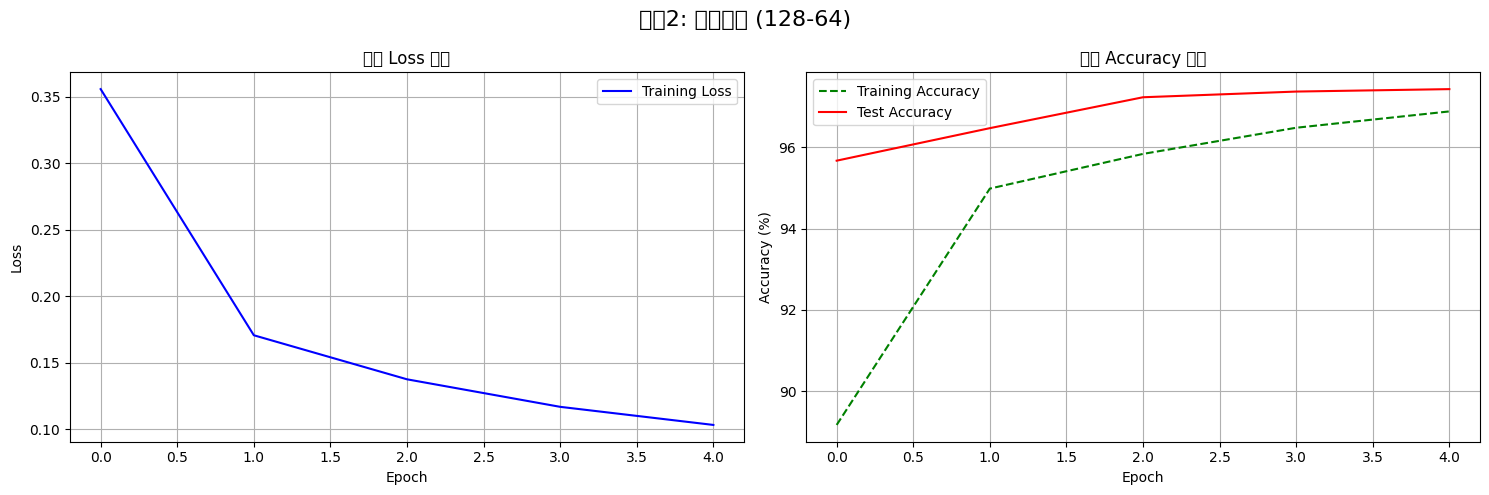


最終測試準確率: 97.43%


In [14]:
# 【修改區塊 2】增加額外的隱藏層
MODEL_TYPE = 'mlp'
HIDDEN_SIZE1 = 128
HIDDEN_SIZE2 = 64  # 增加第二個隱藏層，神經元數為 64
BATCH_SIZE = 64
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
OPTIMIZER_TYPE = 'adam'

print(f"\n=== 實驗 2: 增加額外的隱藏層 ===")
print(f"隱藏層1神經元數: {HIDDEN_SIZE1}")
print(f"隱藏層2神經元數: {HIDDEN_SIZE2} (新增)")

# 重新建立模型和優化器
model_exp2 = MLP(hidden_size1=HIDDEN_SIZE1, hidden_size2=HIDDEN_SIZE2)
optimizer_exp2 = optim.Adam(model_exp2.parameters(), lr=LEARNING_RATE)

# 訓練
train_losses_exp2, train_accuracies_exp2, test_accuracies_exp2 = train_model(
    model_exp2, train_loader, test_loader, NUM_EPOCHS, optimizer_exp2, criterion, device
)

# 繪製結果
plot_results(train_losses_exp2, train_accuracies_exp2, test_accuracies_exp2,
             title=f"實驗2: 雙隱藏層 ({HIDDEN_SIZE1}-{HIDDEN_SIZE2})")


## 修改實驗 3: 改變 Epoch 數量（5 → 10）



=== 實驗 3: 改變 Epoch 數量 ===
Epochs: 10 (原始: 5)
Epoch [1/10], Loss: 0.2913, Train Acc: 91.29%, Test Acc: 96.00%
Epoch [2/10], Loss: 0.1426, Train Acc: 95.72%, Test Acc: 96.94%
Epoch [3/10], Loss: 0.1120, Train Acc: 96.62%, Test Acc: 96.68%
Epoch [4/10], Loss: 0.0959, Train Acc: 96.98%, Test Acc: 97.53%
Epoch [5/10], Loss: 0.0820, Train Acc: 97.36%, Test Acc: 97.43%
Epoch [6/10], Loss: 0.0737, Train Acc: 97.60%, Test Acc: 97.58%
Epoch [7/10], Loss: 0.0663, Train Acc: 97.88%, Test Acc: 97.57%
Epoch [8/10], Loss: 0.0606, Train Acc: 98.04%, Test Acc: 97.87%
Epoch [9/10], Loss: 0.0558, Train Acc: 98.15%, Test Acc: 97.93%


/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 39511 (\N{CJK UNIFIED IDEOGRAPH-9A57}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


Epoch [10/10], Loss: 0.0538, Train Acc: 98.26%, Test Acc: 97.83%


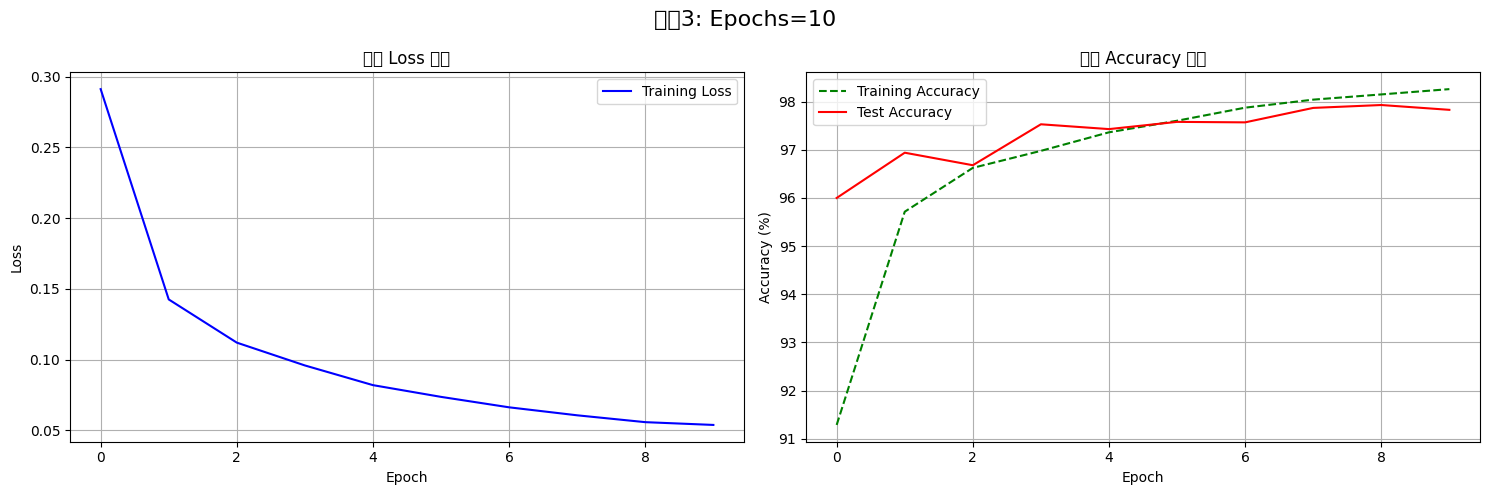


最終測試準確率: 97.83%


In [15]:
# 【修改區塊 3】改變 Epoch 數量
MODEL_TYPE = 'mlp'
HIDDEN_SIZE1 = 128
HIDDEN_SIZE2 = 0
BATCH_SIZE = 64
NUM_EPOCHS = 10  # 從 5 增加到 10
LEARNING_RATE = 0.001
OPTIMIZER_TYPE = 'adam'

print(f"\n=== 實驗 3: 改變 Epoch 數量 ===")
print(f"Epochs: {NUM_EPOCHS} (原始: 5)")

# 重新建立模型和優化器
model_exp3 = MLP(hidden_size1=HIDDEN_SIZE1, hidden_size2=HIDDEN_SIZE2)
optimizer_exp3 = optim.Adam(model_exp3.parameters(), lr=LEARNING_RATE)

# 訓練
train_losses_exp3, train_accuracies_exp3, test_accuracies_exp3 = train_model(
    model_exp3, train_loader, test_loader, NUM_EPOCHS, optimizer_exp3, criterion, device
)

# 繪製結果
plot_results(train_losses_exp3, train_accuracies_exp3, test_accuracies_exp3,
             title=f"實驗3: Epochs={NUM_EPOCHS}")


## 修改實驗 4: 修改 Batch Size（64 → 128）



=== 實驗 4: 修改 Batch Size ===
Batch Size: 128 (原始: 64)
Epoch [1/5], Loss: 0.3382, Train Acc: 90.14%, Test Acc: 95.20%
Epoch [2/5], Loss: 0.1657, Train Acc: 95.12%, Test Acc: 96.31%
Epoch [3/5], Loss: 0.1254, Train Acc: 96.33%, Test Acc: 96.90%
Epoch [4/5], Loss: 0.1039, Train Acc: 96.85%, Test Acc: 97.35%


/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


Epoch [5/5], Loss: 0.0897, Train Acc: 97.22%, Test Acc: 97.52%


/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 39511 (\N{CJK UNIFIED IDEOGRAPH-9A57}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


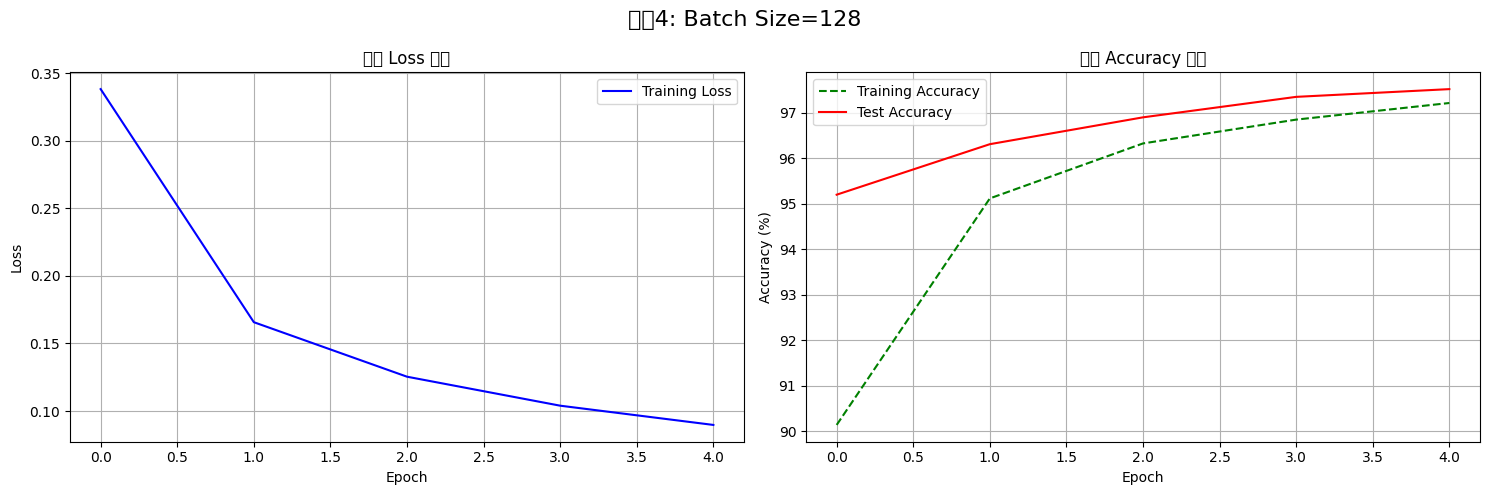


最終測試準確率: 97.52%


In [16]:
# 【修改區塊 4】修改 Batch Size
MODEL_TYPE = 'mlp'
HIDDEN_SIZE1 = 128
HIDDEN_SIZE2 = 0
BATCH_SIZE = 128  # 從 64 增加到 128
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
OPTIMIZER_TYPE = 'adam'

print(f"\n=== 實驗 4: 修改 Batch Size ===")
print(f"Batch Size: {BATCH_SIZE} (原始: 64)")

# 重新建立 DataLoader
train_loader_exp4 = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader_exp4 = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 重新建立模型和優化器
model_exp4 = MLP(hidden_size1=HIDDEN_SIZE1, hidden_size2=HIDDEN_SIZE2)
optimizer_exp4 = optim.Adam(model_exp4.parameters(), lr=LEARNING_RATE)

# 訓練
train_losses_exp4, train_accuracies_exp4, test_accuracies_exp4 = train_model(
    model_exp4, train_loader_exp4, test_loader_exp4, NUM_EPOCHS, optimizer_exp4, criterion, device
)

# 繪製結果
plot_results(train_losses_exp4, train_accuracies_exp4, test_accuracies_exp4,
             title=f"實驗4: Batch Size={BATCH_SIZE}")


## 修改實驗 5: 改變 Optimizer（Adam → SGD）



=== 實驗 5: 改變 Optimizer ===
Optimizer: SGD (原始: Adam)
Epoch [1/5], Loss: 0.6514, Train Acc: 82.25%, Test Acc: 90.90%
Epoch [2/5], Loss: 0.3320, Train Acc: 90.32%, Test Acc: 92.87%
Epoch [3/5], Loss: 0.2760, Train Acc: 92.03%, Test Acc: 93.83%
Epoch [4/5], Loss: 0.2380, Train Acc: 93.19%, Test Acc: 94.61%


/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


Epoch [5/5], Loss: 0.2136, Train Acc: 93.85%, Test Acc: 94.97%


/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 39511 (\N{CJK UNIFIED IDEOGRAPH-9A57}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


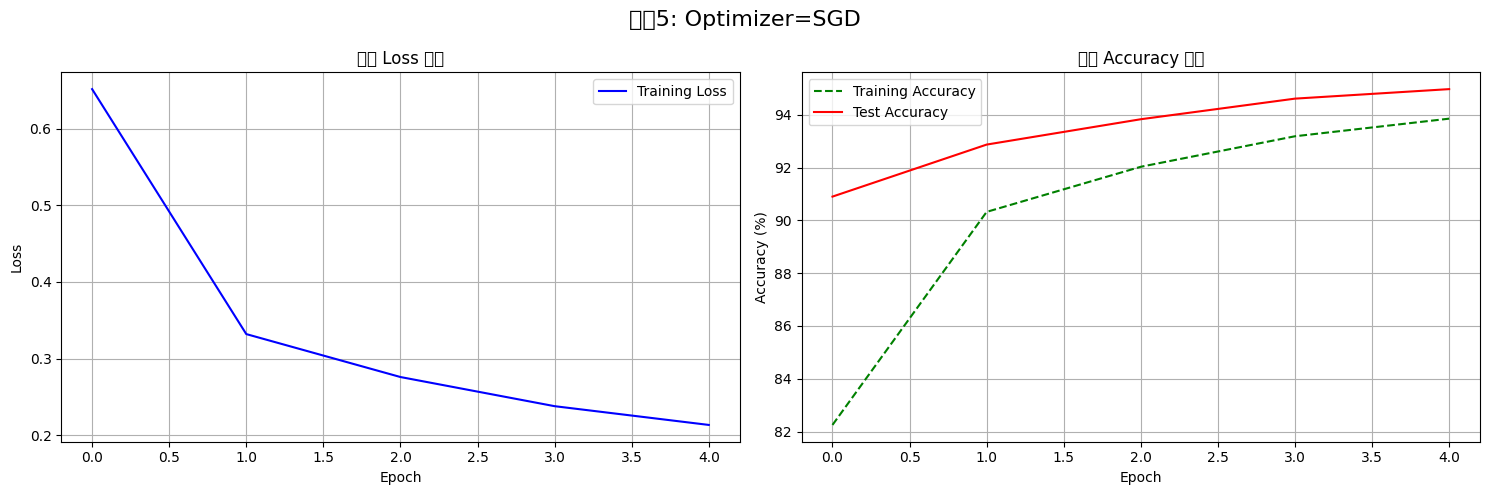


最終測試準確率: 94.97%


In [17]:
# 【修改區塊 5】改變 Optimizer
MODEL_TYPE = 'mlp'
HIDDEN_SIZE1 = 128
HIDDEN_SIZE2 = 0
BATCH_SIZE = 64
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
OPTIMIZER_TYPE = 'sgd'  # 從 Adam 改為 SGD

print(f"\n=== 實驗 5: 改變 Optimizer ===")
print(f"Optimizer: {OPTIMIZER_TYPE.upper()} (原始: Adam)")

# 重新建立 DataLoader
train_loader_exp5 = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader_exp5 = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 重新建立模型和優化器
model_exp5 = MLP(hidden_size1=HIDDEN_SIZE1, hidden_size2=HIDDEN_SIZE2)
optimizer_exp5 = optim.SGD(model_exp5.parameters(), lr=LEARNING_RATE, momentum=0.9)

# 訓練
train_losses_exp5, train_accuracies_exp5, test_accuracies_exp5 = train_model(
    model_exp5, train_loader_exp5, test_loader_exp5, NUM_EPOCHS, optimizer_exp5, criterion, device
)

# 繪製結果
plot_results(train_losses_exp5, train_accuracies_exp5, test_accuracies_exp5,
             title=f"實驗5: Optimizer={OPTIMIZER_TYPE.upper()}")


## 修改實驗 6: 嘗試不同的 Learning Rate（0.001 → 0.01）



=== 實驗 6: 改變 Learning Rate ===
Learning Rate: 0.01 (原始: 0.001)
Epoch [1/5], Loss: 0.3877, Train Acc: 88.65%, Test Acc: 93.32%
Epoch [2/5], Loss: 0.3105, Train Acc: 91.27%, Test Acc: 93.42%
Epoch [3/5], Loss: 0.3038, Train Acc: 91.88%, Test Acc: 94.22%
Epoch [4/5], Loss: 0.2931, Train Acc: 92.29%, Test Acc: 93.88%


/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


Epoch [5/5], Loss: 0.2935, Train Acc: 92.45%, Test Acc: 94.54%


/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1910739637.py:25: UserWarning: Glyph 39511 (\N{CJK UNIFIED IDEOGRAPH-9A57}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


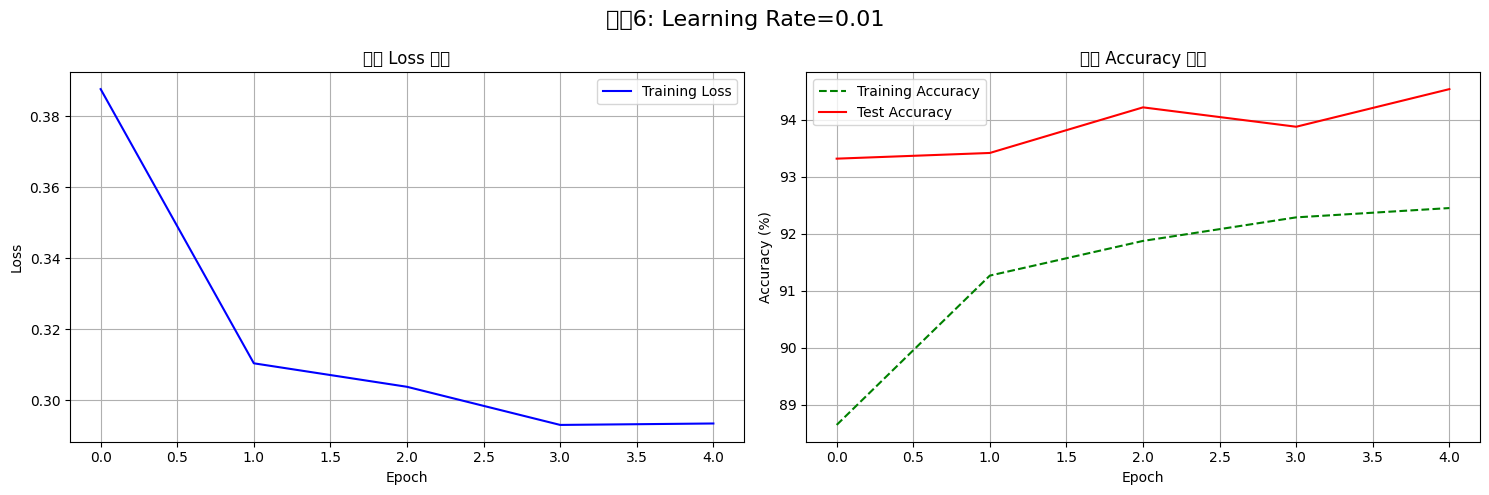


最終測試準確率: 94.54%


In [18]:
# 【修改區塊 6】嘗試不同的 Learning Rate
MODEL_TYPE = 'mlp'
HIDDEN_SIZE1 = 128
HIDDEN_SIZE2 = 0
BATCH_SIZE = 64
NUM_EPOCHS = 5
LEARNING_RATE = 0.01  # 從 0.001 增加到 0.01
OPTIMIZER_TYPE = 'adam'

print(f"\n=== 實驗 6: 改變 Learning Rate ===")
print(f"Learning Rate: {LEARNING_RATE} (原始: 0.001)")

# 重新建立 DataLoader
train_loader_exp6 = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader_exp6 = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 重新建立模型和優化器
model_exp6 = MLP(hidden_size1=HIDDEN_SIZE1, hidden_size2=HIDDEN_SIZE2)
optimizer_exp6 = optim.Adam(model_exp6.parameters(), lr=LEARNING_RATE)

# 訓練
train_losses_exp6, train_accuracies_exp6, test_accuracies_exp6 = train_model(
    model_exp6, train_loader_exp6, test_loader_exp6, NUM_EPOCHS, optimizer_exp6, criterion, device
)

# 繪製結果
plot_results(train_losses_exp6, train_accuracies_exp6, test_accuracies_exp6,
             title=f"實驗6: Learning Rate={LEARNING_RATE}")


## 結果比較與總結


/tmp/ipython-input-3540997120.py:37: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3540997120.py:37: UserWarning: Glyph 30990 (\N{CJK UNIFIED IDEOGRAPH-790E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3540997120.py:37: UserWarning: Glyph 35373 (\N{CJK UNIFIED IDEOGRAPH-8A2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3540997120.py:37: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3540997120.py:37: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3540997120.py:37: UserWarning: Glyph 39511 (\N{CJK UNIFIED IDEOGRAPH-9A57}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3540997120.py:37: UserWarning: Glyph 38577 (\N{CJK UNIFIED IDEOGRAPH-96B1}) missi


=== 各實驗最終測試準確率比較 ===
基礎設定: 97.71%
實驗1: 隱藏層256: 97.95%
實驗2: 雙隱藏層: 97.43%
實驗3: Epochs=10: 97.83%
實驗4: Batch=128: 97.52%
實驗5: SGD: 94.97%
實驗6: LR=0.01: 94.54%


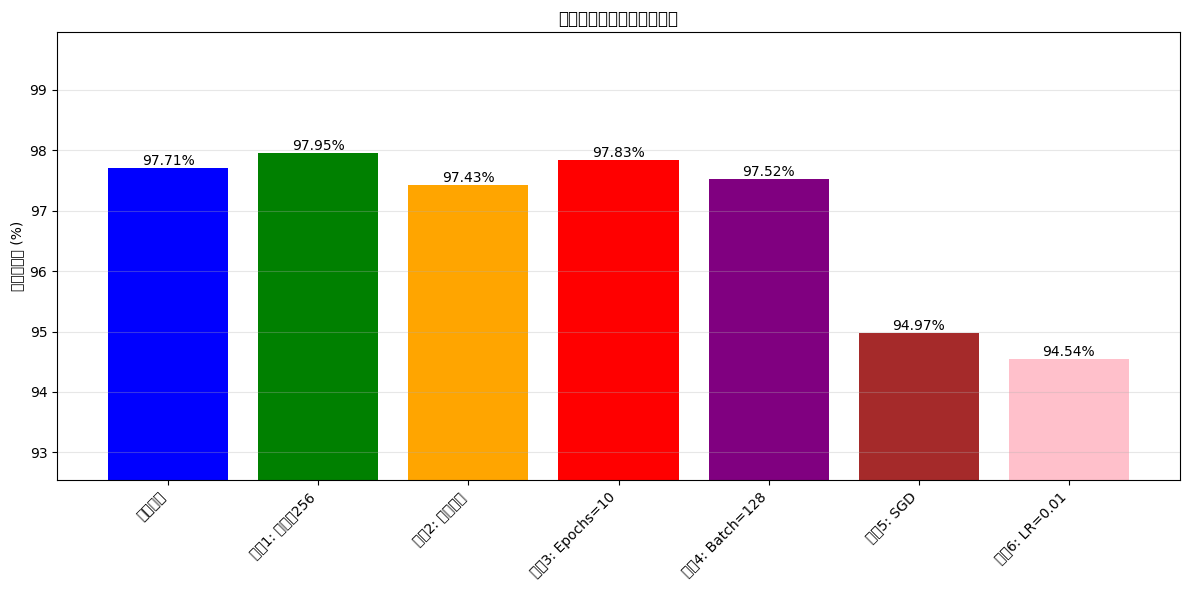

In [19]:
# 比較所有實驗的最終測試準確率
experiments = {
    '基礎設定': test_accuracies[-1] if 'test_accuracies' in locals() else None,
    '實驗1: 隱藏層256': test_accuracies_exp1[-1],
    '實驗2: 雙隱藏層': test_accuracies_exp2[-1],
    '實驗3: Epochs=10': test_accuracies_exp3[-1],
    '實驗4: Batch=128': test_accuracies_exp4[-1],
    '實驗5: SGD': test_accuracies_exp5[-1],
    '實驗6: LR=0.01': test_accuracies_exp6[-1],
}

print("\n=== 各實驗最終測試準確率比較 ===")
for exp_name, acc in experiments.items():
    if acc is not None:
        print(f"{exp_name}: {acc:.2f}%")

# 繪製比較圖
fig, ax = plt.subplots(figsize=(12, 6))
exp_names = list(experiments.keys())
acc_values = [v for v in experiments.values() if v is not None]
exp_names_filtered = [name for name, v in experiments.items() if v is not None]

bars = ax.bar(exp_names_filtered, acc_values, color=['blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink'])
ax.set_ylabel('測試準確率 (%)')
ax.set_title('各實驗最終測試準確率比較')
ax.set_ylim([min(acc_values) - 2, max(acc_values) + 2])
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)

# 在柱狀圖上顯示數值
for bar, acc in zip(bars, acc_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 修改說明

### 已實作的修改項目：

1. **【修改區塊 1】調整隱藏層神經元數量**：將第一個隱藏層從 128 增加到 256
2. **【修改區塊 2】增加額外的隱藏層**：在原有隱藏層後增加第二個隱藏層（64 個神經元）
3. **【修改區塊 3】改變 Epoch 數量**：從 5 增加到 10
4. **【修改區塊 4】修改 Batch Size**：從 64 增加到 128
5. **【修改區塊 5】改變 Optimizer**：從 Adam 改為 SGD
6. **【修改區塊 6】嘗試不同的 Learning Rate**：從 0.001 增加到 0.01

### 觀察重點：

- **Loss 曲線**：觀察訓練過程中損失函數的變化趨勢
- **Accuracy 曲線**：觀察訓練準確率和測試準確率的變化，注意是否有過擬合（overfitting）現象
- **最終測試準確率**：比較不同設定下的模型表現

### 預期觀察：

- 增加隱藏層神經元數量可能會提高模型容量，但也可能導致過擬合
- 增加 Epoch 數量可能會提高準確率，但需要更多訓練時間
- 改變 Batch Size 會影響訓練穩定性和速度
- 不同的 Optimizer 有不同的收斂特性
- Learning Rate 過大可能導致訓練不穩定，過小則訓練速度慢
